## Assignment 5

This assignment is based on Bayesian statistics to carry out Stock return analysis.

## Learning outcomes

- Bayesian analysis for stock return data
- Build models for different distributions of data
- Compare models

In this assignment, you will use the Baysesian approach for analysis of stock return data.
In particular, you will model the data as a normal distribution and will estimate distribution parameters using Markov chain Monte Carlo technique (MCMC).

The MCMC sampler draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values.
It is recommended to use PyMC library for these computations; PyMC is a Python library for Bayesian analysis.

__NOTE__: The 'data.csv' file included with the assignment contains the data.
The data were downloaded from Quandl, the code used to download data and calculate daily return is provided.    
Use that file instead if you aren't able to read the data, or if you have reached the limit for calls to the API.

__Getting data from Quandl__ 
To download stock data from Quandl you should create an account for quandl (https://www.quandl.com/).

Quandl is a platform for financial, economic, and alternative data that serves investment professionals. Quandl sources data from over 500 publishers. All Quandl's data are accessible via an API. API access is possible through packages for multiple programming languages including R, Python.

Required imports for this project are given below.  Make sure you have all libraries required for this project installed.  You may use _conda_ or _pip_ based on your set up.


In [2]:
#required imports

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt
import seaborn as sns
from datetime import datetime

## Get the data:
pd.core.common.is_list_like = pd.api.types.is_list_like # resolves datareader error
from pandas_datareader import data
# For all libraries please install the necessary libraries 
#If the above fails, you might need to do something like this:
#This is to show how you install pandas-datareader, you might need to do this for all libraries
#conda install pandas-datareader
#or
#pip install pandas-datareader
#Depending on your setup

from IPython.display import Image
from datetime import datetime
%matplotlib inline

After installing the necessary libraries, we will proceed to download the data.
You might have to set an environment variable for pymc3 package.  
You can do this by    
For linux:
export mkl_threading_layer=gnu or set this in your bashrc file.

For windows:
Add it in your environment variables

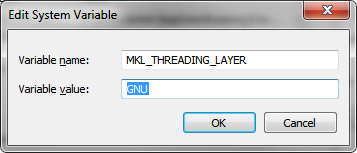

### Returns
Extract historical data for Apple (AAPL) [2015 - 2016], calculate daily returns, and estimate the mean daily return. Remove NaN from dataset. Plot histogram of daily returns.

Use code below to download data.

For this you will need to install the library quandl:    
conda install -c anaconda quandl

You will also need an API Key that is generated when you create an account.  

In [3]:
# if you wish to use attached 'data.csv' uncomment the line below
data = pd.read_csv('data.csv')

returns=data['Adj. Close'].pct_change()

returns = returns.dropna()*100

#### Question 1

1. Plot the returns and draw a histogram to see the distribution


In [4]:
#Let's take a look at the data
data.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,504.000000,504.000000,504.000000,504.000000,5.040000e+02,504.000000,504.0,504.000000,504.000000,504.000000,504.000000,5.040000e+02
mean,112.337202,113.334260,111.276580,112.321240,4.513926e+07,0.008452,1.0,108.686202,109.650625,107.662440,108.672217,4.513926e+07
std,10.939777,10.904892,10.880545,10.875629,2.036889e+07,0.066751,0.0,9.915366,9.866239,9.891972,9.865848,2.036889e+07
min,90.000000,91.670000,89.470000,90.340000,1.147592e+07,0.000000,1.0,87.955883,89.587953,87.437920,88.288161,1.147592e+07
25%,105.415000,106.295000,104.612500,105.632500,3.129263e+07,0.000000,1.0,102.137316,103.416408,101.326879,102.044599,3.129263e+07
50%,112.065000,112.915000,110.640000,112.120000,4.018978e+07,0.000000,1.0,108.680845,109.951485,107.714314,109.069200,4.018978e+07
75%,120.325000,121.472500,119.300000,120.185000,5.310691e+07,0.000000,1.0,116.138602,116.651514,115.244837,116.005284,5.310691e+07
max,134.455000,134.540000,131.400000,133.000000,1.622063e+08,0.570000,1.0,128.233349,128.314416,125.839962,126.931724,1.622063e+08


In [8]:
# Checking the returns series
returns.describe()

count    503.000000
mean       0.031662
std        1.579874
min       -6.570657
25%       -0.716921
50%        0.040068
75%        0.850964
max        6.496328
Name: Adj. Close, dtype: float64

(array([  3.,   4.,  14.,  55., 162., 179.,  61.,  18.,   3.,   4.]),
 array([-6.57065707, -5.26395859, -3.95726011, -2.65056163, -1.34386315,
        -0.03716468,  1.2695338 ,  2.57623228,  3.88293076,  5.18962923,
         6.49632771]),
 <BarContainer object of 10 artists>)

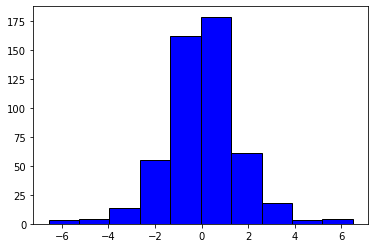

In [9]:
#Plotting a histogram
plt.hist(returns, color = 'blue', edgecolor = 'black')

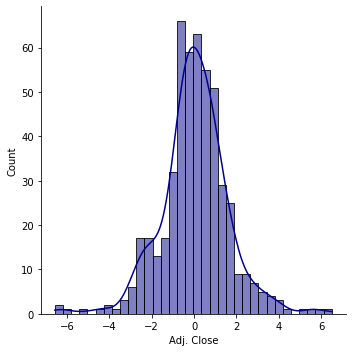

In [10]:
#KDE Plot
sns.displot(returns, kde=True, color = 'darkblue') 

In [11]:
#The KDE plot of the returns also shows a Gaussian-like distribution

In the cell below, the model for daily return simulations is shown. Since the daily returns histogram shows bell-shaped distribution, the normal distribution is used for likelihood computation.

This model uses un-informative priors - Uniform distribution for both parameters of the normal distribution ("mu" and 'sigma").

In [12]:
with pm.Model() as model_n:
    #Prior
    mu = pm.Uniform("mu", lower=-10, upper=10, testval=0)
    sigma = pm.Uniform("sigma", lower=-6, upper=6, testval=0.0001)
    
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(10000, chains=3, step=step, start=start, progressbar=True)
    burned_trace = trace[3000::]

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

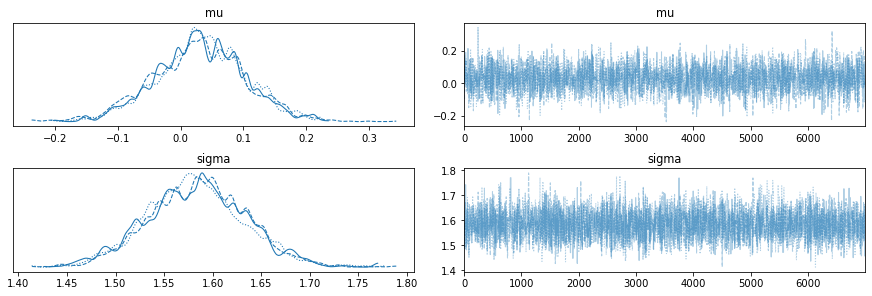

In [13]:
pm.traceplot(burned_trace)

C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

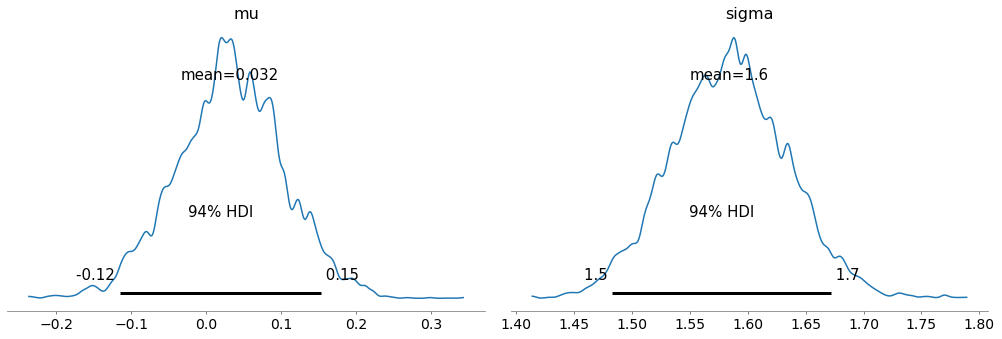

In [14]:
pm.plot_posterior(burned_trace)

In [15]:
pm.summary(trace)

C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.031,0.071,-0.109,0.159,0.001,0.001,3824.0,3051.0,3804.0,3794.0,1.0
sigma,1.583,0.050,1.485,1.673,0.001,0.001,4239.0,4239.0,4239.0,4723.0,1.0


#### Question 2

Improve the model for daily returns given above.
Choose different prior distributions for parameters of the likelihood distribution - Mean $\mu$ and Standard Deviation $\sigma$.

To tune the model, try several different distributions with various spread/dispersion values (for example, Uniform, Normal, HalfNormal) for priors, and different numbers of samples.
By inspecting posterior distribution of parameters, pick the value that produces the smoothest, most convergent chains. 

Present posterior distribution graphically. 

In [16]:
# YOUR CODE HERE

After playing with different distribuitions, dispersion values for priors, and 
number of samples I decided to choice the following model. 
- $\mu$, mean of a population. Looking at the KDE plot of the returns above, we see that values are between approximately -6 and 6, so I set the boundaries of the Uniform distribution to be -6 and 6
- $\sigma$, standard deviation of a population. Can only be positive, hence I 
used HalfNormal with a range from 0 to 6
- I also decided to use NUTS algorithm which helps to cut autocorrelation
- Number of samples is 20,000

In [17]:
#Model
with pm.Model() as model_g:
    #Prior
    mu = pm.Uniform("mu", lower=-6, upper=6)
    sigma = pm.HalfNormal("sigma", sd=6)
    
    #Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior - Auto-assigning NUTS sampler...
    trace_g = pm.sample(20000, chains=3, progressbar=True) 
    burned_trace_g = trace_g[3000::]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 3 chains for 1_000 tune and 20_000 draw iterations (3_000 + 60_000 draws total) took 41 seconds.


C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

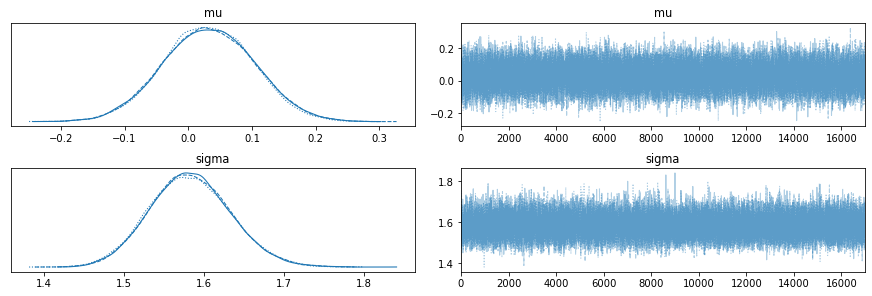

In [18]:
#Let's plot the model burned trace
pm.traceplot(burned_trace_g)

I would like to highlight a few things:
- Our sampling chains for mu and sigma parameters seem well converged and stationary (left)
- The maximum posterior estimate of mu and sigma (the peak in the left side distributions) is very close to the true parameters
- We observed the hairy caterpillar shape, point randomly scattered around some mean,  for our mu and sigma (right)

C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

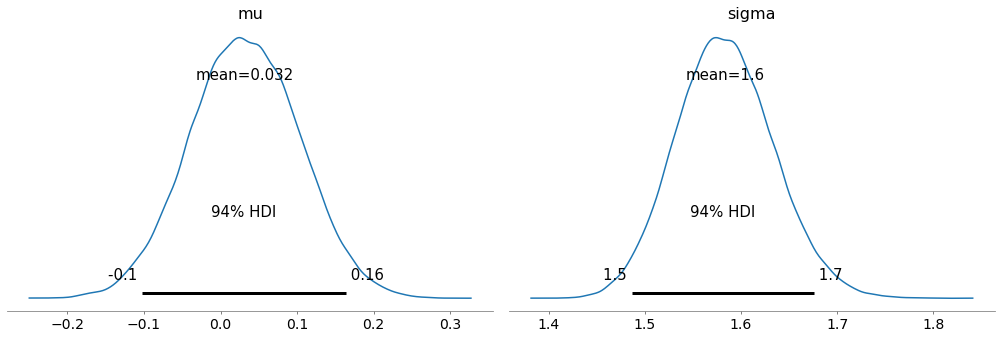

In [21]:
# PLOT POSTERIOR DISTRIBUTION
pm.plot_posterior(burned_trace_g)

In [22]:
pm.summary(burned_trace_g)

C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.032,0.071,-0.103,0.163,0.0,0.0,44261.0,29731.0,44277.0,37697.0,1.0
sigma,1.583,0.051,1.486,1.676,0.0,0.0,43964.0,43814.0,44138.0,36057.0,1.0


- r_hat shows chains convergence (1.0) 
- We can can interpret that there is 94% probability the mu values are approximately between -0.1 and 0.17
- 94% of posterior sigma values are approximately between 1.5 and 1.7

#### Question 3

As a validation check of model performance, predict the distribution of daily returns from the obtained posterior distributions. To generate the data, use the pymc3 function for sampling posterior distribution with an appropriately chosen number of samples from the trace.

Present results of predicted distribution graphically as a histogram.

In [23]:
# Sample posterior to obtain the distribution of daily returns
ppc_returns = pm.sample_posterior_predictive(burned_trace_g, samples=500, model=model_g)

C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


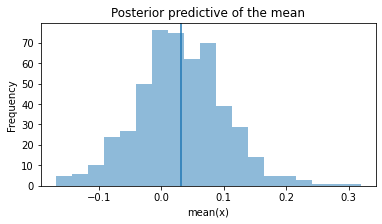

In [26]:
# Plot obtained distribution of daily return
_, ax = plt.subplots(figsize=(6, 3))
ax.hist(ppc_returns['likelihood'].mean(axis=0), bins=19,alpha=0.5)
ax.axvline(returns.values.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'mu\n0'}>,
        <AxesSubplot:title={'center':'mu\n1'}>,
        <AxesSubplot:title={'center':'mu\n2'}>],
       [<AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'sigma\n2'}>]], dtype=object)

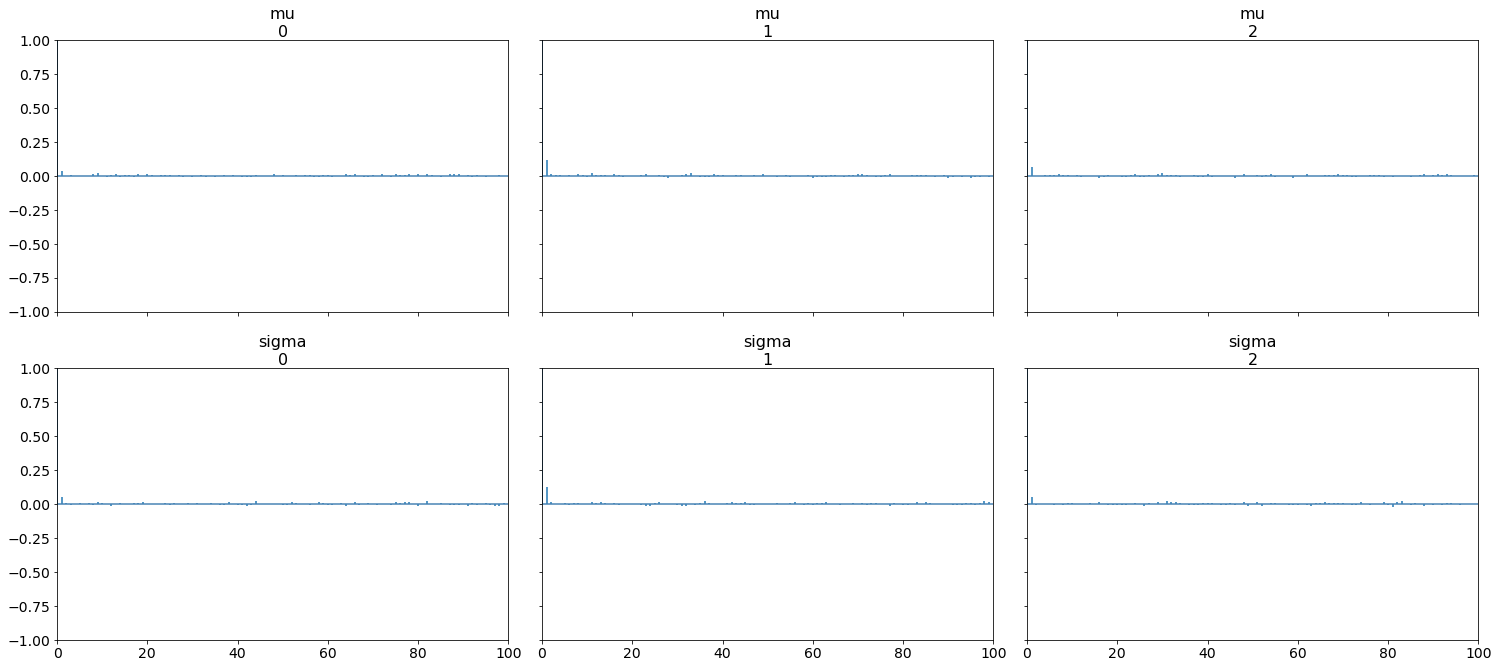

In [28]:
#Let's check our outocorrelation plot
pm.autocorrplot(burned_trace_g)

#### Question 4

(a) Identify the parameter of interest in the prediction model. What would be the best prior distribution to produce these parameters? 

(b) What is the HDI in the posteriors for the parameters you named in 4a? What number of samples was used to build this model? 

(c) Does the data generated when predicting daily returns from posterior distribution deviate significantly from the true distribution?

In [29]:
# YOUR ANSWERS TO 4(a-c).

(a) Response:

I tried different prior distributions and parameters values, sometimes a mix of boths:
 - Uniform for both mu and sigma with values from -10 to 10 and 0 to 6 respectively
 - Normal for both mu and sigma
 - Changin only the number of samples and not the values for the paremeters (mu and sigma)
 - Uniform for mu and halfNormal for sigma with adjusted values  

After this "try and error", I decided to use the following for my model:
- $\mu$ paremeter - Based on the KDE plot of the returns, I set set the boundaries of a Uniform distribution to be -6 and 6
- $\sigma$, this can only be positive so I used HalfNormal with a sd of 6
- I decided to use NUTS algorithm instead of Metropolis
- I got a slighhly smoother trace_plot when I increased the number of samples from 10,000 to 20.000

(b) Response:

Looking at the plot_posterion and the summary table in Q2, we can say that:
- There is 94% probability the mu values are approximately between -0.1 and 0.17
- 94% of posterior sigma values are approximately between 1.5 and 1.7
- I used 20,000 for the number of samples in the model

(c) Response:

Looking at the posterior predictive checks / sample_posterior_predictive in Q3. We can suggest that:
- The inferred mean is very close to the actual returns mean
- I used 500 samples

In [34]:
 'Original mean: 0.031662 vs the estimated mean:', pm.summary(burned_trace_g).iloc[0,0]

C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


('Original mean: 0.031662 vs the estimated mean:', 0.032)

In [36]:
 'Original sigma: 1.579874 vs the estimated sigma:', pm.summary(burned_trace_g).iloc[1,0]

C:\Users\ronaldg\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


('Original sigma: 1.579874 vs the estimated sigma:', 1.583)